### LSTM

Test on AAPL data

In [14]:
# Imports
import numpy as np
from numpy import concatenate
from pandas import read_csv, to_datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Concatenate

In [15]:
lstm_df = read_csv('../../data/clean/baseline_transformed_dataset_AAPL.csv', index_col='Date')
print(lstm_df.shape)
lstm_df.head()

(2514, 2)


,AAPL(t-1),AAPL(t)
Date,,
2015-01-05,24.320435,23.635284
2015-01-06,23.635284,23.637510
2015-01-07,23.637510,23.968960
2015-01-08,23.968960,24.889904
2015-01-09,24.889904,24.916597


In [16]:
# Train-Test Split
split = int(lstm_df.shape[0]*0.8)
train = lstm_df[:split]
test = lstm_df[split:]

print('Split Shape:', train.shape, test.shape)

Split Shape: (2011, 2) (503, 2)


In [17]:
# Initialise variables
lag_steps = 1
num_features = 1
epochs = 10
batch_size = 32

In [18]:
# Scale to avoid distance calculation bias
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test) # Avoid data leakage

# Separate into features and target (last column)
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
X_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]

# Reshape features for LSTM
X_train = X_train.reshape((X_train.shape[0], lag_steps, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], lag_steps, X_test.shape[1]))

print('Train Shape:', X_train.shape, y_train.shape)
print('Test Shape:', X_test.shape, y_test.shape)

Train Shape: (2011, 1, 1) (2011,)
Test Shape: (503, 1, 1) (503,)


Epoch 1/10


/opt/anaconda3/envs/MLApps/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 - 0s - 8ms/step - loss: 0.0692
Epoch 2/10
63/63 - 0s - 804us/step - loss: 0.1900
Epoch 3/10
63/63 - 0s - 705us/step - loss: 0.1152
Epoch 4/10
63/63 - 0s - 699us/step - loss: 0.0312
Epoch 5/10
63/63 - 0s - 830us/step - loss: 0.0334
Epoch 6/10
63/63 - 0s - 736us/step - loss: 0.0285
Epoch 7/10
63/63 - 0s - 723us/step - loss: 0.0224
Epoch 8/10
63/63 - 0s - 714us/step - loss: 0.0213
Epoch 9/10
63/63 - 0s - 723us/step - loss: 0.0187
Epoch 10/10
63/63 - 0s - 717us/step - loss: 0.0202


/var/folders/0f/_9krm_xj6v3fx4gv1vgm01mw0000gn/T/ipykernel_1616/788695707.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


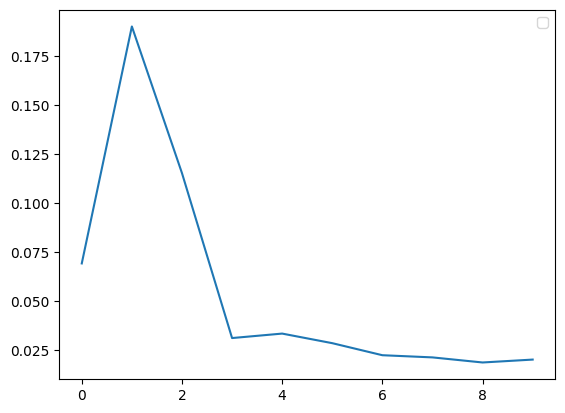

In [19]:
# Initiate LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Model fitting
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

# Plot training progression
plt.plot(history.history['loss'])
plt.legend()
plt.show()

In [20]:
# Get predicted values
yhat = model.predict(X_test)

# Reshaping back into 2D for inverse scaling
X_test_inv = X_test.reshape((X_test.shape[0], X_test.shape[2])) 

# Concatenate and Inverse Scaling
# Prediction
inv_yhat = concatenate((X_test_inv, yhat), axis=1) # Required to get back original scale
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, num_features*lag_steps] # Extract target_variable

# Validation
y_test_inv = y_test.reshape((len(y_test), 1))
inv_y = concatenate((X_test_inv, y_test_inv), axis=1) # Both arrays must have same dimensions
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, num_features*lag_steps]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [21]:
# Get Test Errors
mae = np.sqrt(mean_absolute_error(inv_y, inv_yhat))
print('LSTM Test MAE: %.3f' % mae)

mse = mean_squared_error(inv_y, inv_yhat)
print('LSTM Test MSE: %.3f' % mse)

LSTM Test MAE: 1.386
LSTM Test MSE: 6.590


### Basic Sentiment Models

In [22]:
sent_df = read_csv('../../data/clean/sentiment_analysis/sentiment_analysis_headlines_AAPL.csv')
sent_df.drop('ticker', axis=1, inplace=True)
# sent_df['pub_date'] = to_datetime(sent_df['pub_date'])
print(sent_df.shape)
sent_df.head()

(2143, 14)


,pub_date,headline,vader_pos,vader_neg,vader_neu,vader_label,drob_pos,drob_neg,drob_neu,drob_label,deb_pos,deb_neg,deb_neu,deb_label
0,2015-04-07,M.B.A. Programs That Get You Where You Want to Go,0.126,0.0,0.874,Positive,0.000063,0.999864,0.000073,Negative,0.963603,0.003316,0.033081,Positive
1,2015-04-14,What We’re Reading,0.000,0.0,1.000,Neutral,0.000071,0.999868,0.000061,Positive,0.005000,0.015302,0.979697,Neutral
2,2015-04-13,IBM Creates Watson Health to Analyze Medical Data,0.231,0.0,0.769,Positive,0.000064,0.999881,0.000054,Positive,0.227212,0.018740,0.754048,Neutral
3,2015-04-22,What’s That on Beyoncé’s Wrist? Let Me Guess ....,0.000,0.0,1.000,Neutral,0.000072,0.999858,0.000070,Positive,0.287033,0.348115,0.364852,Neutral
4,2015-04-01,Daily Report: Tech Leaders Come Together to Op...,0.000,0.0,1.000,Neutral,0.000267,0.999467,0.000267,Positive,0.162412,0.451023,0.386565,Negative


In [23]:
# Function to aggregate sentiment using a voting system
def aggregate_sentiment(row):
    sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
    
    # Get the list of sentiment labels
    sentiments = [row['vader_label'], row['drob_label'], row['deb_label']]
    
    # Count occurrences of each sentiment
    sentiment_counts = {'Positive': sentiments.count('Positive'), 
                        'Neutral': sentiments.count('Neutral'), 
                        'Negative': sentiments.count('Negative')}
    
    # Choose the sentiment with the highest count, resolving ties by choosing the first
    majority_sentiment = max(sentiment_counts, key=sentiment_counts.get)

    return sentiment_map[majority_sentiment]

# Function to aggregate sentiments by pub_date with rounding
def aggregate_by_pub_date(sent_df):
    # Apply the aggregation function to the entire dataframe
    sent_df['aggregated_sentiment'] = sent_df.apply(aggregate_sentiment, axis=1)
    
    # Group by pub_date and calculate the average sentiment per day
    aggregated_sent_df = sent_df.groupby('pub_date')['aggregated_sentiment'].mean().to_frame()
    
    # Round the aggregated sentiment and convert to int (-1, 0, or 1)
    aggregated_sent_df['aggregated_sentiment'] = aggregated_sent_df['aggregated_sentiment'].round().astype(int)
    
    # Set 'pub_date' as the index of the result
    aggregated_sent_df.reset_index(inplace=True)
    aggregated_sent_df.set_index('pub_date', inplace=True)
    
    return aggregated_sent_df

In [24]:
# Aggregate the sentiment by pub_date
aggregated_sent_df = aggregate_by_pub_date(sent_df)
aggregated_sent_df.value_counts()

aggregated_sentiment
 0                      608
 1                      565
-1                      206
Name: count, dtype: int64

In [25]:
# Reindex sent_df to follow lstm_df and fill NA
print(f"aggregated_sent_df index range: {aggregated_sent_df.index.min()} to {aggregated_sent_df.index.max()}")
print(f"lstm_df index range: {lstm_df.index.min()} to {lstm_df.index.max()}")

aggregated_sent_df_reindex = aggregated_sent_df.reindex(lstm_df.index, method=None)
aggregated_sent_df_reindex['aggregated_sentiment'] = aggregated_sent_df_reindex['aggregated_sentiment'].fillna(0).astype(int)
aggregated_sent_df_reindex.value_counts()

aggregated_sent_df index range: 2015-01-02 to 2024-12-18
lstm_df index range: 2015-01-05 to 2024-12-30


aggregated_sentiment
 0                      1868
 1                       475
-1                       171
Name: count, dtype: int64

There is some inconsistency here that needs to be addressed.

#### Train-Test Split

In [26]:
# Train-Test Split
split = int(aggregated_sent_df_reindex.shape[0]*0.8)
sent_train = aggregated_sent_df_reindex[:split]
sent_test = aggregated_sent_df_reindex[split:]

print('Split Shape:', sent_train.shape, sent_test.shape)

Split Shape: (2011, 1) (503, 1)


### Concat Method

In [27]:
# LSTM Model
lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]), name="stock_input")
lstm_output = LSTM(100, name="lstm_layer")(lstm_input)
lstm_dense = Dense(32, activation="relu")(lstm_output)

In [28]:
# Sentiment Input
sentiment_input = Input(shape=(aggregated_sent_df_reindex.shape[1],))
sentiment_dense = Dense(8, activation='relu')(sentiment_input)

In [29]:
# Concatenate both models
concatenated = Concatenate(name="concatenation_layer")([lstm_dense, sentiment_dense])

# Add final prediction layers
dense_layer = Dense(64, activation='relu', name="dense_final")(concatenated)
output = Dense(1, name="output_layer")(dense_layer)

# Define the final model
model = Model(inputs=[lstm_input, sentiment_input], outputs=output)

Epoch 1/10
63/63 - 1s - 9ms/step - loss: 0.0158
Epoch 2/10
63/63 - 0s - 878us/step - loss: 0.1055
Epoch 3/10
63/63 - 0s - 795us/step - loss: 0.0502
Epoch 4/10
63/63 - 0s - 785us/step - loss: 0.0082
Epoch 5/10
63/63 - 0s - 780us/step - loss: 0.0011
Epoch 6/10
63/63 - 0s - 778us/step - loss: 6.0776e-04
Epoch 7/10
63/63 - 0s - 844us/step - loss: 2.6925e-04
Epoch 8/10
63/63 - 0s - 795us/step - loss: 2.0362e-04
Epoch 9/10
63/63 - 0s - 804us/step - loss: 1.9093e-04
Epoch 10/10
63/63 - 0s - 759us/step - loss: 1.8389e-04


/var/folders/0f/_9krm_xj6v3fx4gv1vgm01mw0000gn/T/ipykernel_1616/3924066876.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


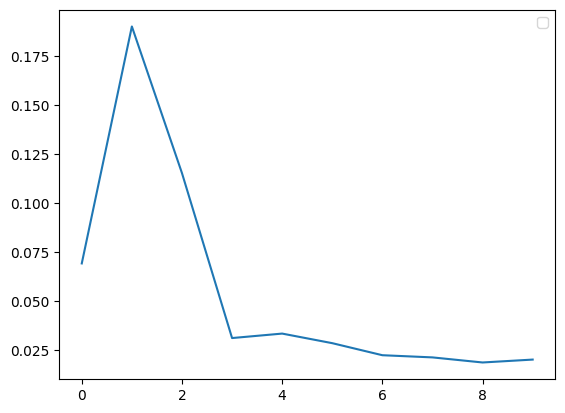

In [30]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit([X_train, sent_train], y_train, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

# Plot training progression
plt.plot(history.history['loss'])
plt.legend()
plt.show()

In [31]:
# Get predicted values
yhat = model.predict([X_test, sent_test])

# Reshaping back into 2D for inverse scaling
X_test_inv = X_test.reshape((X_test.shape[0], X_test.shape[2])) 

# Concatenate and Inverse Scaling
# Prediction
concat_inv_yhat = concatenate((X_test_inv, yhat), axis=1) # Required to get back original scale
concat_inv_yhat = scaler.inverse_transform(concat_inv_yhat)
concat_inv_yhat = concat_inv_yhat[:, num_features*lag_steps] # Extract target_variable

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [32]:
# Get Test Errors
mae = np.sqrt(mean_absolute_error(inv_y, concat_inv_yhat))
print('LSTM Test MAE: %.3f' % mae)

mse = mean_squared_error(inv_y, concat_inv_yhat)
print('LSTM Test MSE: %.3f' % mse)

LSTM Test MAE: 1.422
LSTM Test MSE: 7.133


### Actual vs Predicted Plot

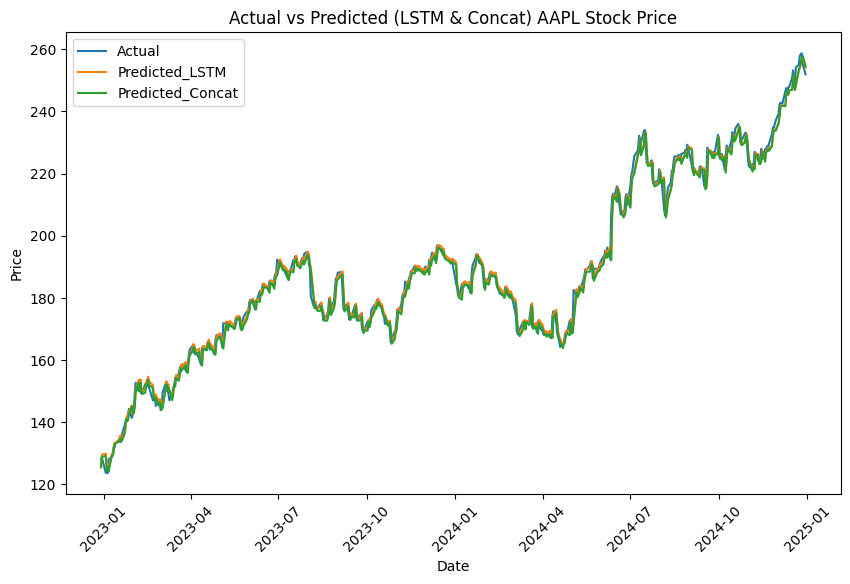

In [33]:
# Convert index to datetime
test.index = to_datetime(test.index)

# Validation plot
plt.figure(figsize=(10, 6))
plt.plot(test.index, inv_y, label='Actual')
plt.plot(test.index, inv_yhat, label='Predicted_LSTM')
plt.plot(test.index, concat_inv_yhat, label='Predicted_Concat')

# Format the x-axis to show quarterly ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator((1,4,7,10)))  # Quarterly ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Quarter

# Labels and title
plt.title('Actual vs Predicted (LSTM & Concat) AAPL Stock Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Price')
plt.legend()
plt.show()